In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install tqdm
%pip install matplotlib
%pip install piq
%pip install imageio
%pip install opencv-python
%pip install tensorboard
%pip install pycolmap
%pip install pyquaternion

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import imageio.v3 as iio
import json
import pycolmap
import os
from pathlib import Path
from piq import ssim
import shutil

# Build Gaussian Renderer CUDA Kernel

In [ ]:
from setuptools import setup
from torch.utils.cpp_extension import BuildExtension, CUDAExtension

setup(
    name='gsplat_render',
    ext_modules=[
        CUDAExtension(
            name='gsplat_render',
            sources=['gsplat_render.cu', 'gsplat_render.cpp'],
            extra_compile_args={'cxx': ['-O3'], 'nvcc': ['-O3']},
        )
    ],
    cmdclass={'build_ext': BuildExtension},
)

OSError: CUDA_HOME environment variable is not set. Please set it to your CUDA install root.

In [ ]:
import gsplat_render

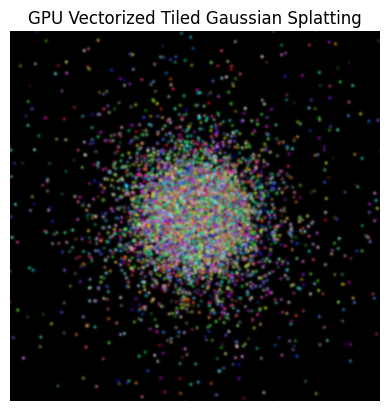

In [ ]:
# --- Configuration ---
H, W = 512, 512
tile_size = 16
num_tiles_x = W // tile_size
num_tiles_y = H // tile_size
num_gaussians = 20000
radius = 6.0  # pixels

device = torch.device("cuda")

# --- 1. Generate Gaussians in 3D space ---
torch.manual_seed(0)
xyz = torch.randn(num_gaussians, 3, device=device) + torch.tensor([0.0, 0.0, 2.0], device=device)
colors = torch.rand(num_gaussians, 3, device=device)
alpha = torch.full((num_gaussians,), 0.6, device=device)

# --- 2. Project to screen space ---
fx = fy = 50
cx, cy = W / 2, H / 2
K = torch.tensor([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], device=device)
xy = xyz[:, :2] / xyz[:, 2:3]
uv = (K[:2, :2] @ xy.T).T + K[:2, 2]
depth = xyz[:, 2]

# --- 3. Duplicate Gaussians across overlapping tiles ---
tile_ids, uv_list, depth_list, color_list, alpha_list = [], [], [], [], []

for i in range(num_gaussians):
    min_tx = max(0, int((uv[i, 0] - radius) // tile_size))
    max_tx = min(num_tiles_x - 1, int((uv[i, 0] + radius) // tile_size))
    min_ty = max(0, int((uv[i, 1] - radius) // tile_size))
    max_ty = min(num_tiles_y - 1, int((uv[i, 1] + radius) // tile_size))
    for tx in range(min_tx, max_tx + 1):
        for ty in range(min_ty, max_ty + 1):
            tile_id = ty * num_tiles_x + tx
            tile_ids.append(tile_id)
            uv_list.append(uv[i])
            depth_list.append(depth[i])
            color_list.append(colors[i])
            alpha_list.append(alpha[i])

tile_ids = torch.tensor(tile_ids, device=device)
uv = torch.stack(uv_list)
depth = torch.stack(depth_list)
colors = torch.stack(color_list)
alpha = torch.stack(alpha_list)

# --- 4. Sort by tile + depth ---
sort_key = tile_ids * 1e3 + depth
idx = torch.argsort(sort_key)
tile_ids, uv, depth, colors, alpha = tile_ids[idx], uv[idx], depth[idx], colors[idx], alpha[idx]

# --- 5. Precompute pixel coords per tile ---
tile_pixel_coords = []
for ty in range(num_tiles_y):
    for tx in range(num_tiles_x):
        x = torch.arange(tx * tile_size, (tx + 1) * tile_size, device=device)
        y = torch.arange(ty * tile_size, (ty + 1) * tile_size, device=device)
        gx, gy = torch.meshgrid(x, y, indexing='xy')
        coords = torch.stack([gx, gy], dim=-1).reshape(-1, 2)
        tile_pixel_coords.append(coords)
tile_pixel_coords = torch.stack(tile_pixel_coords)  # (num_tiles, tile_area, 2)

# --- 6. Gaussian params ---
cov = torch.eye(2, device=device) * 3.0
inv_cov = torch.inverse(cov)

# --- 7. Output buffers ---
image = torch.zeros((H, W, 3), device=device)
alpha_buf = torch.zeros((H, W), device=device)

# --- 8. Rasterize per tile ---
for tid in range(num_tiles_x * num_tiles_y):
    in_tile = tile_ids == tid
    if not in_tile.any():
        continue

    coords = tile_pixel_coords[tid]  # (tile_area, 2)
    px, py = coords[:, 0].long(), coords[:, 1].long()
    idx = (py, px)

    guv = uv[in_tile]       # (M, 2)
    gcol = colors[in_tile]  # (M, 3)
    galpha = alpha[in_tile] # (M,)

    diff = coords.unsqueeze(0) - guv.unsqueeze(1)  # (M, P, 2)
    exp_term = -0.5 * torch.einsum("mpk,kl,mpk->mp", diff, inv_cov, diff)
    weights = torch.exp(exp_term).clamp(max=1.0)  # (M, P)

    for m in range(guv.shape[0]):
        a = galpha[m] * (1 - alpha_buf[idx]) * weights[m]
        alpha_buf[idx] += a
        image[idx] += a.unsqueeze(1) * gcol[m]

# --- 9. Show result ---
plt.imshow(image.clamp(0, 1).cpu().numpy())
plt.title("GPU Vectorized Tiled Gaussian Splatting")
plt.axis('off')
plt.show()

# Structure From Motion Extraction to NERF Camera Poses/Point Cloud

In [16]:
def colmap_to_nerf_point(points):
    # Same flip to move world into NeRF-style frame where Z-forward = negative
    return points @ torch.diag(torch.tensor([1.0, -1.0, -1.0], dtype=points.dtype, device=points.device)).T

def colmap_to_nerf_pose(pose):
    flip = torch.diag(torch.tensor([1.0, -1.0, -1.0], dtype=pose.dtype, device=pose.device))
    R = pose[:3, :3] @ flip
    t = pose[:3, 3]
    return torch.cat([
        torch.cat([R, t.view(3, 1)], dim=1),
        torch.tensor([[0.0, 0.0, 0.0, 1.0]], dtype=pose.dtype, device=pose.device)
    ], dim=0)

In [17]:
def sfm_extract(image_dir, device='cuda'):

    image_dir = Path(image_dir)
    database_path = Path("temp/database.db")
    sfm_path = Path("temp/sfm_output")

    if sfm_path.exists() and any(sfm_path.iterdir()):
        print(f"[INFO] Loading existing SfM reconstruction from {sfm_path}")
        reconstruction = pycolmap.Reconstruction(str(sfm_path / "0"))
    else:
        # Clean up previous runs
        if database_path.exists():
            database_path.unlink()
        if sfm_path.exists():
            shutil.rmtree(sfm_path)
        sfm_path.mkdir(parents=True, exist_ok=True)

        # 1. Extract features
        print("[INFO] Extracting features...")

        pycolmap.extract_features(
            database_path=str(database_path),
            image_path=str(image_dir),
            camera_model='PINHOLE',
            camera_mode='SINGLE'
        )

        # 2. Match features
        print("[INFO] Matching features...")
        pycolmap.match_exhaustive(str(database_path))

        # 3. Incremental mapping
        print("[INFO] Performing incremental mapping...")
        reconstructions = pycolmap.incremental_mapping(
            str(database_path),
            str(image_dir),
            str(sfm_path),
            initial_image_pair_callback=lambda: print("[INFO] Initial image pair registered."),
            next_image_callback=lambda: print("[INFO] Next image registered.")
        )

        if not reconstructions:
            raise RuntimeError("No reconstructions found")
        reconstruction = reconstructions[0]

    print(f"[INFO] Number of registered images: {len(reconstruction.images)}")
    print(f"[INFO] Number of 3D points: {len(reconstruction.points3D)}")

    # Extract camera poses and intrinsics
    pose_c2w_dict = {}
    intrinsics_dict = {}
    camera_models = set()

    for img_id, img in reconstruction.images.items():
        img_name = os.path.basename(img.name)
        pose = torch.tensor(img.cam_from_world.matrix(), dtype=torch.float32, device=device)
        intrinsics = torch.tensor(img.camera.params, dtype=torch.float32, device=device)

        pose_c2w_dict[img_name] = colmap_to_nerf_pose(pose)
        intrinsics_dict[img_name] = intrinsics

        camera = img.camera
        camera_models.add(camera.model)

        print(f"[CAMERA INFO] Image ID: {img_id}")
        print(f" - Image name: {img.name}")
        print(f" - Camera ID: {camera.camera_id}")
        print(f" - Camera model: {camera.model}")
        print(f" - Image size: {camera.width} x {camera.height}")
        print(f" - Intrinsic parameters ({len(camera.params)}): {camera.params}")
        print(f" - cam_from_world:\n{img.cam_from_world.matrix()}")
        print("-" * 60)

    if len(camera_models) == 1:
        print(f"[INFO] Single camera model detected: {list(camera_models)[0]}")
    else:
        print(f"[WARNING] Multiple camera models detected: {camera_models}")

    # Extract 3D points
    points = (
        torch.stack([
            colmap_to_nerf_point(torch.tensor(p.xyz, dtype=torch.float32, device=device))
            for p in reconstruction.points3D.values()
        ])
        if reconstruction.points3D else
        torch.empty((0, 3), device=device)
    )

    return pose_c2w_dict, intrinsics_dict, points

# Dataset with Optional Structure-From-Motion Support

In [30]:
def to_homogeneous(pose_3x4):
    bottom_row = torch.tensor([[0, 0, 0, 1]], dtype=pose_3x4.dtype, device=pose_3x4.device)
    pose_4x4 = torch.cat([pose_3x4, bottom_row], dim=0)
    return pose_4x4

In [ ]:
class NeRFDataset(Dataset):
    def __init__(self, json_path, image_size=(512, 512), device='cuda', sfm_poses=None, sfm_intrinsics=None):
        with open(json_path, 'r') as f:
            meta = json.load(f)

        self.frames = meta['frames']
        self.camera_angle_x = meta['camera_angle_x']
        self.image_size = image_size  # (W, H)
        self.device = device
        self.base_dir = os.path.dirname(json_path)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(image_size[::-1])  # (H, W) for torchvision
        ])

        self.sfm_poses = sfm_poses
        self.sfm_intrinsics = sfm_intrinsics

    def __len__(self):
        return len(self.frames)

    def _rescale_intrinsics(self, intrinsics, orig_size, new_size):
        scale_x = new_size[0] / orig_size[0]
        scale_y = new_size[1] / orig_size[1]
        intrinsics = intrinsics.clone()
        intrinsics[0] *= scale_x  # fx
        intrinsics[1] *= scale_y  # fy
        intrinsics[2] *= scale_x  # cx
        intrinsics[3] *= scale_y  # cy
        return intrinsics

    def _load_pose(self, frame, img_filename):
        if self.sfm_poses and img_filename in self.sfm_poses:
            return to_homogeneous(self.sfm_poses[img_filename]).to(self.device)
        # Invert NeRF transform_matrix if no SfM
        return torch.inverse(torch.tensor(frame['transform_matrix'], dtype=torch.float32).to(self.device))

    def _load_intrinsics(self, img_filename, orig_size):
        W, H = self.image_size
        if self.sfm_intrinsics and img_filename in self.sfm_intrinsics:
            fx, fy, cx, cy = self.sfm_intrinsics[img_filename].cpu()[:4]
            intrinsics = torch.tensor([fx, fy, cx, cy], dtype=torch.float32)
            intrinsics = self._rescale_intrinsics(intrinsics, orig_size, self.image_size)
        else:
            # Default NeRF-style intrinsics (assuming square pixels)
            focal_x = 0.5 * W / np.tan(0.5 * self.camera_angle_x)
            focal_y = 0.5 * H / np.tan(0.5 * self.camera_angle_x)
            intrinsics = torch.tensor([focal_x, focal_y, W / 2, H / 2], dtype=torch.float32)

        K = torch.tensor([
            [intrinsics[0], 0, intrinsics[2]],
            [0, intrinsics[1], intrinsics[3]],
            [0, 0, 1]
        ], dtype=torch.float32, device=self.device)

        return K

    def __getitem__(self, idx):
        with torch.no_grad():  # No gradients needed for dataset loading
            frame = self.frames[idx]
            img_filename = os.path.basename(frame['file_path']) + '.png'
            img_path = os.path.join(self.base_dir, frame['file_path'] + '.png')

            # Load raw image to get original size
            raw = iio.imread(img_path).astype(np.float32) / 255.0
            if raw.shape[-1] == 4:  # Drop alpha if present
                raw = raw[:, :, :3]
            orig_height, orig_width = raw.shape[:2]

            # Transform image (resize, normalize)
            image = self.transform(raw).to(self.device)

            # Load camera pose and intrinsics
            pose = self._load_pose(frame, img_filename)
            K = self._load_intrinsics(img_filename, (orig_width, orig_height))

            return image, pose, K

# Gaussian Initialization

In [ ]:
def estimate_scale(points, k=3):
    # Compute mean distance to k nearest neighbors
    dists = torch.cdist(points, points)
    dists[torch.arange(points.shape[0]), torch.arange(points.shape[0])] = float('inf')
    topk, _ = torch.topk(dists, k=k, largest=False)
    return topk.mean(dim=1, keepdim=True).expand(-1, 3)  # (N, 3)

In [ ]:
def init_gaussians(sfm_points=None, device='cuda', N_default=10000):

    # If we don't have Structure from Motion points, we just create a cloud.
    if sfm_points:
        xyz = sfm_points.to(device)
    else:
        xyz = torch.randn(N_default, 3, device=device) * 1.0  # unit sphere cloud
        xyz = xyz / xyz.norm(dim=1, keepdim=True).clamp(min=1e-6)  # normalize to radius 1
        xyz += 0.05 * torch.randn_like(xyz)  # jitter to avoid uniform sphere

    N = xyz.shape[0]

    # Unit quaternions (0, 0, 0, 1)
    quat = torch.zeros(N, 4, device=device)
    quat[:, 3] = 1.0

    # Initialize alpha in [0,1], centered around 0.5
    alpha = torch.clamp(0.5 + 0.1 * torch.randn(N, device=device), 0.0, 1.0)

    # Spherical Harmonics coefficients
    sh_order = 3 # R, G, B
    n_sh_coeffs = (sh_order + 1) ** 2
    sh_coeff = torch.clamp(0.5 + 0.1 * torch.randn(N, 3, n_sh_coeffs, device=device), 0.0, 1.0)

    return {
        'xyz': nn.Parameter(xyz),
        'scale': nn.Parameter(torch.log(estimate_scale(xyz))),  # log scale for exponential later
        'quat': nn.Parameter(quat),
        'alpha': nn.Parameter(alpha),
        'sh_coeff': nn.Parameter(sh_coeff),
    }

# Differentiable Rasterizer for Gaussians

In [ ]:
def quat_to_rot_matrix(q):
    """
    q: (N, 4) quaternion in (x, y, z, w) format
    Returns: (N, 3, 3) rotation matrices
    """
    q = F.normalize(q, dim=-1)  # ensure unit quaternion

    x, y, z, w = q[:, 0], q[:, 1], q[:, 2], q[:, 3]

    xx, yy, zz = x * x, y * y, z * z
    xy, xz, yz = x * y, x * z, y * z
    wx, wy, wz = w * x, w * y, w * z

    R = torch.stack([
        1 - 2*(yy + zz), 2*(xy - wz),     2*(xz + wy),
        2*(xy + wz),     1 - 2*(xx + zz), 2*(yz - wx),
        2*(xz - wy),     2*(yz + wx),     1 - 2*(xx + yy)
    ], dim=-1).reshape(-1, 3, 3)

    return R

In [ ]:
def quat_and_scale_to_covariance(q, s):
    """
    q: (N, 4) quaternions (x, y, z, w)
    s: (N, 3) scaling vectors (s_x, s_y, s_z)
    Returns: (N, 3, 3) covariance matrices Σ
    """
    R = quat_to_rot_matrix(q)        # (N, 3, 3)
    S = torch.diag_embed(s)                     # (N, 3, 3)
    SS_T = torch.matmul(S, S.transpose(1, 2))   # (N, 3, 3)
    cov = torch.matmul(R, torch.matmul(SS_T, R.transpose(1, 2)))  # (N, 3, 3)
    return cov

In [ ]:
def perspective_jacobian(cam_points, fx, fy):
    """
    cam_points: (N, 3) camera-space coordinates
    fx, fy: focal lengths
    Returns: (N, 2, 3) Jacobian of perspective projection
    """
    x, y, z = cam_points[:, 0], cam_points[:, 1], cam_points[:, 2]
    eps = 1e-8  # avoid divide by zero

    J = torch.zeros((cam_points.shape[0], 2, 3), device=cam_points.device)
    
    J[:, 0, 0] = fx / (z + eps)
    J[:, 0, 1] = 0
    J[:, 0, 2] = -fx * x / (z**2 + eps)

    J[:, 1, 0] = 0
    J[:, 1, 1] = fy / (z + eps)
    J[:, 1, 2] = -fy * y / (z**2 + eps)

    return J

In [ ]:
def project_gaussians(points, cov, pose_w2c, K):

    N = points.shape[0]
    device = points.device

    # Convert positions to homogeneous coordinates (N,4)
    ones = torch.ones((N, 1), device=device)
    positions_h = torch.cat([points, ones], dim=-1)

    # Transform to camera coordinates (N,4)
    positions_cam_h = (pose_w2c @ positions_h.T).T
    positions_cam = positions_cam_h[:, :3]

    # Extract rotation W (3x3)
    W = pose_w2c[:3, :3]

    # Rotate covariance matrices from world to camera coords:
    # Σ_c = W Σ Wᵀ
    W_expand = W.unsqueeze(0).expand(N, 3, 3)
    cov_cam = W_expand @ cov @ W_expand.transpose(1, 2)

    # Compute 2D projected points via perspective projection
    x, y, z = positions_cam[:, 0], positions_cam[:, 1], positions_cam[:, 2]
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    u = fx * (x / z) + cx
    v = fy * (y / z) + cy
    proj_points = torch.stack([u, v], dim=1)

    # Compute Jacobian J of perspective projection (N, 2, 3)
    eps = 1e-8
    J = torch.zeros((N, 2, 3), device=device)
    J[:, 0, 0] = fx / (z + eps)
    J[:, 0, 2] = -fx * x / (z * z + eps)
    J[:, 1, 1] = fy / (z + eps)
    J[:, 1, 2] = -fy * y / (z * z + eps)

    # Project covariance: Σ' = J Σ_c Jᵀ
    cov2d = J @ cov_cam @ J.transpose(1, 2)

    return cov2d, proj_points


# Adaptive Control of Gaussians

In [ ]:
def delete_gaussians(gaussians, optimizer_xyz, optimizer_rest, eps_alpha):
    with torch.no_grad():
        alpha = torch.sigmoid(gaussians['opacity']).squeeze(1)
        keep_mask = alpha >= eps_alpha

        if not torch.any(~keep_mask):
            return

        for key, param in gaussians.items():
            gaussians[key] = nn.Parameter(param[keep_mask])

        optimizer_xyz.param_groups[0]['params'] = [gaussians['xyz']]
        optimizer_rest.param_groups[0]['params'] = [p for k, p in gaussians.items() if k != 'xyz']

In [ ]:
def sample_from_gaussian(mean, scale_log, quat, num_samples=2):
    scale = torch.exp(scale_log)
    cov = quat_and_scale_to_covariance(quat, scale)
    dist = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    return dist.sample((num_samples,))

In [ ]:
def split_gaussians(base, mask, split_scale):
    xyz = base['xyz'][mask]
    scale_log = base['scale'][mask]
    quat = base['quaternion'][mask]

    scale = scale_log - torch.log(torch.tensor(split_scale, device=scale_log.device))
    new_xyz = []

    for i in range(xyz.shape[0]):
        samples = sample_from_gaussian(
            xyz[i],
            torch.exp(scale_log[i]) / split_scale,
            quat[i],
            num_samples=2
        )
        new_xyz.append(samples)
    new_xyz = torch.cat(new_xyz, dim=0)

    return {
        'xyz': new_xyz,
        'color': base['color'][mask].repeat_interleave(2, dim=0),
        'opacity': base['opacity'][mask].repeat_interleave(2, dim=0),
        'scale': scale.repeat_interleave(2, dim=0),
        'quaternion': quat.repeat_interleave(2, dim=0)
    }


In [ ]:
def clone_gaussians(base, grad_unit, mask, offset_scale):
    return {
        'xyz': base['xyz'][mask] + grad_unit[mask] * offset_scale,
        'color': base['color'][mask],
        'opacity': base['opacity'][mask],
        'scale': base['scale'][mask],
        'quaternion': base['quaternion'][mask]
    }

In [ ]:
def densify_gaussians(gaussians, optimizer_xyz, optimizer_rest, pose_w2c, settings):
    tau_pos = settings['tau_pos']
    densify_factor = settings['densify_factor']
    scale_threshold = settings['scale_threshold']
    clone_offset_scale = settings['clone_offset_scale']
    split_scale = settings['split_scale']
    
    with torch.no_grad():
        if gaussians['xyz'].grad is None:
            print("No positional grads, skipping densify")
            return

        grad_view = (pose_w2c[:3, :3] @ gaussians['xyz'].grad.T).T
        grad_norms = grad_view.norm(dim=1)

        high_grad_mask = grad_norms > tau_pos
        indices = torch.nonzero(high_grad_mask).squeeze(1)
        if indices.numel() == 0:
            print("No Gaussians to densify")
            return

        num_to_densify = int(densify_factor * indices.numel())
        densify_indices = indices[torch.randperm(indices.numel())[:num_to_densify]]

        base = {k: gaussians[k][densify_indices] for k in ['xyz', 'color', 'opacity', 'scale', 'quaternion']}
        grad_unit = grad_view[densify_indices] / grad_view[densify_indices].norm(dim=1, keepdim=True).clamp(min=1e-8)

        scale = torch.exp(base['scale'])
        is_small = scale.mean(dim=1) < scale_threshold

        cloned = clone_gaussians(base, grad_unit, is_small, offset_scale=clone_offset_scale)
        split = split_gaussians(base, is_small.logical_not(), split_scale=split_scale)

        for key in gaussians:
            new_data = torch.cat([cloned[key], split[key]], dim=0)
            gaussians[key] = nn.Parameter(torch.cat([gaussians[key], new_data], dim=0))

        print(f"[Densify] Added {cloned['xyz'].shape[0] + split['xyz'].shape[0]} new Gaussians")

        optimizer_xyz.param_groups[0]['params'] = [gaussians['xyz']]
        optimizer_rest.param_groups[0]['params'] = [p for k, p in gaussians.items() if k != 'xyz']

In [ ]:
def reset_floaters(gaussians, alpha_reset_value=-5.0):
    with torch.no_grad():
        if 'opacity' in gaussians:
            gaussians['opacity'].data.fill_(alpha_reset_value)
            print(f"[Reset Floaters] Set all opacity logits to {alpha_reset_value}")

# Training Gaussian Splatter

In [ ]:
def save_img(tensor, filename):
    # Clamp values to valid range [0, 1]
    tensor = torch.clamp(tensor, 0.0, 1.0)

    # Check for NaNs or infinite values and replace them safely
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        print(f"Warning: Image contains NaN or Inf values when saving {filename}")
        tensor = torch.nan_to_num(tensor, nan=0.0, posinf=1.0, neginf=0.0)

    # Convert tensor to HWC numpy uint8 image
    img_np = (tensor.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8)

    # Write image using imageio
    iio.imwrite(filename, img_np)

In [ ]:
def train(settings):
    assert settings is not None, "Settings dictionary must be provided."
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load SfM data
    poses_w2c_dict, intrinsics_dict, points = sfm_extract(settings['image_path'], device=device)

    # Initialize Gaussians
    gaussians = init_gaussians(points, device=device)

    # Dataset + DataLoader with batch size
    dataset = NeRFDataset(
        json_path=settings['json_path'],
        image_size=settings['image_size'],
        device=device,
        sfm_poses=poses_w2c_dict,
        sfm_intrinsics=intrinsics_dict
    )
    loader = DataLoader(dataset, batch_size=settings['batch_size'], shuffle=True)

    # Optimizers
    optimizer_xyz = torch.optim.Adam([gaussians['xyz']], lr=settings['lr_xyz_init'])
    optimizer_rest = torch.optim.Adam(
        [p for k, p in gaussians.items() if k != 'xyz'],
        lr=settings['lr_rest']
    )

    # Built-in PyTorch exponential LR scheduler for optimizer_xyz
    scheduler_xyz = torch.optim.lr_scheduler.ExponentialLR(
        optimizer_xyz,
        gamma=settings.get('lr_decay_factor', 0.99)  # decay factor per epoch
    )

    pbar = tqdm(range(settings['epochs']), desc="Training")

    for epoch in pbar:
        running_loss = 0.0

        for images, poses_w2c, Ks in loader:
            images = images.to(device)
            poses_w2c = poses_w2c.to(device)
            Ks = Ks.to(device)

            optimizer_xyz.zero_grad()
            optimizer_rest.zero_grad()

            # Render batch
            render = []
            for i in range(images.shape[0]):
                r = render_gaussians(gaussians, poses_w2c[i], Ks[i], settings['image_size'])
                render.append(r)
            render = torch.stack(render)

            # Compute loss (L1 + D-SSIM)
            l1_loss = F.l1_loss(render, images)
            dssim_loss = 1 - ssim(render, images)
            loss = (1 - settings['lambda']) * l1_loss + settings['lambda'] * dssim_loss

            loss.backward()
            optimizer_xyz.step()
            optimizer_rest.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(loader)
        current_lr = scheduler_xyz.get_last_lr()[0]
        pbar.set_postfix(loss=f"{avg_loss:.4f}", lr_xyz=f"{current_lr:.6f}")

        # Step the scheduler once per epoch
        scheduler_xyz.step()

        # Delete + Densify Gaussians
        delete_gaussians(gaussians, optimizer_xyz, optimizer_rest, eps_alpha=settings['eps_alpha'])

        if epoch % settings['densify_interval'] == 0:
            densify_gaussians(gaussians, optimizer_xyz, optimizer_rest, poses_w2c[0], settings)

        if epoch % settings['floaters_reset_interval'] == 0:
            reset_floaters(gaussians, settings['floaters_reset_value'])

        # Optional logging
        if (epoch + 1) % settings.get('log_interval', 10) == 0 or epoch == 0:
            save_img(render[0], f"render_{epoch+1}.png")
            save_img(images[0], f"image_{epoch+1}.png")

    # Save final render
    save_img(render[0], "final.png")

# Execute Training

In [ ]:
settings = {
    'json_path': "nerf_synthetic/lego/transforms_train.json",
    'image_path': "nerf_synthetic/lego/train",
    'image_size': (256, 256),

    'epochs': 1000,
    'batch_size': 4,

    'lr_xyz_init': 1e-3,
    'lr_rest': 1e-2,
    'lr_decay_factor': 0.95,

    'lambda': 0.2,                   # weight for D-SSIM loss
    'tau_pos': 0.0002,               # gradient threshold for densification
    'densify_factor': 0.5,           # percentage of high-grad Gaussians to densify
    'scale_threshold': 0.05,         # threshold for small vs large Gaussians
    'clone_offset_scale': 0.01,      # offset applied when cloning small Gaussians
    'split_scale': 1.6,              # factor to split large Gaussians
    'eps_alpha': 0.01,               # alpha below which Gaussians are deleted
    'floaters_reset_interval': 3000, # how often to reset alpha
    'floaters_reset_value': -5.0,    # value to reset alpha to
    'densify_interval': 100,         # how often to densify
    'log_interval': 2                # how often to save images
}

In [ ]:
train(settings)

[INFO] Loading existing SfM reconstruction from temp/sfm_output
[INFO] Number of registered images: 100
[INFO] Number of 3D points: 12313
[CAMERA INFO] Image ID: 100
 - Image name: r_99.png
 - Camera ID: 1
 - Camera model: CameraModelId.PINHOLE
 - Image size: 800 x 800
 - Intrinsic parameters (4): [1103.6899312  1103.61495604  400.          400.        ]
 - cam_from_world:
[[-0.62799559 -0.67440199  0.38833426 -0.37334119]
 [ 0.60756971 -0.11306518  0.78617766 -2.12819661]
 [-0.48629269  0.72965623  0.48075066  2.66994006]]
------------------------------------------------------------
[CAMERA INFO] Image ID: 99
 - Image name: r_97.png
 - Camera ID: 1
 - Camera model: CameraModelId.PINHOLE
 - Image size: 800 x 800
 - Intrinsic parameters (4): [1103.6899312  1103.61495604  400.          400.        ]
 - cam_from_world:
[[ 0.86666036  0.44336217 -0.22875711  0.09149356]
 [-0.28242589  0.81397968  0.50761471 -1.97338265]
 [ 0.4112608  -0.37532261  0.83066087  2.47002224]]
------------------

NameError: name 'get_points' is not defined